In [1]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import Quandl
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from tabulate import tabulate
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
from PIL import Image
import urllib.request as url
import io

## Two Popular ML Textbooks

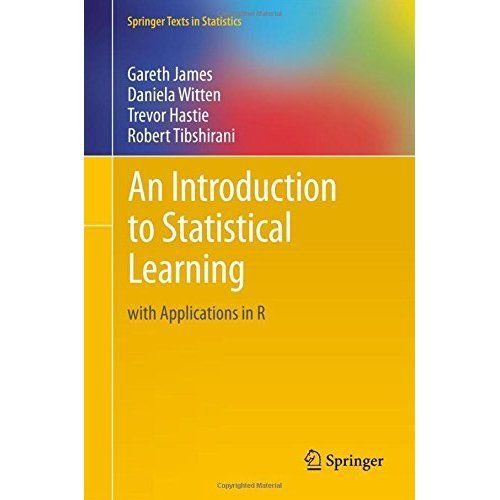

In [2]:
fd1 = url.urlopen("http://i.ebayimg.com/images/i/161977842252-0-1/s-l1000.jpg")
fd2 = url.urlopen("http://ecx.images-amazon.com/images/I/51MucLjt9IL._SX439_BO1,204,203,200_.jpg")
fd3 = url.urlopen("http://ecx.images-amazon.com/images/I/519HYQKubEL._SX328_BO1,204,203,200_.jpg")
image_file1 = io.BytesIO(fd1.read())
Image.open(image_file1) 

* This textbook could be viewed as a replacement of Ernst Berndt's *The Practice of Econometrics: Classic and Contempory*.  

* As an innovation, it contains a useful discussion of cross-validation, an innovation brought to us as the result of **voluminous** data.  

* For example, in order to estimate the variability of a linear regression fit, we can repeatedly draw different samples from our training data, fitting a linear representation to each new sample, and examining the extext to which the resulting fits differ.  

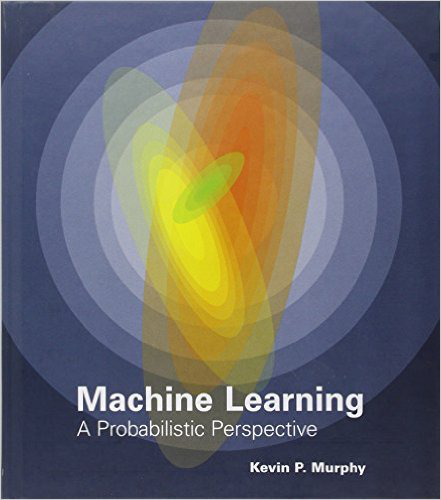

In [3]:
image_file2 = io.BytesIO(fd2.read())
Image.open(image_file2) 

This textbook is considered by many computer scientists to be one of the most comprehensive ML textbooks currently on the market.  Two interesting facts that say something:
1. It was so rushed to market that the first physical edition contained hundreds of typos.
2. "Probabilistic Perspective" = Bayesian.

In ML, there is not much discussion of the frequentist/Bayesian schism.  The same practitioner can one day fit a Bayesian network to make a probabilistic prediction and the next fit a neural network to label faces.  

## For the Masses

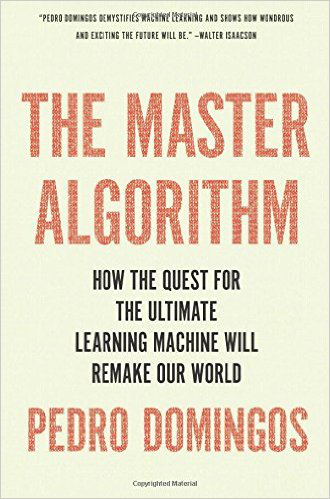

In [4]:
image_file3 = io.BytesIO(fd3.read())
Image.open(image_file3) 

This book is an enjoyable non-technical book that describes what the author believes to be the five tribes of ML:

1. Inverse deduction: learning by decision rules using some variant of decision trees
2. Backpropagation: learning by minimizing error using linear models or nonlinear neural networks
3. Evolutionary: learning by adaptation and survival 
4. Probabilistic inference: application of Bayes' theorem
5. Analogization: learning by example using so-called support vector machines (could be binary logit model)

Econometricians do 2, 4, and 5.  1 will become increasingly popular for both regression and classification.  3 is well outside the scope of both statistics and econometrics, but is an interesting approach to algorithmic learning that mirrors evolution through natural selection.

The author makes the case that artificial intelligence will require an algorithm that unifies these tribes.  (Personally, I believe the author is a little panglossian about the impact on society of true artificial intelligence.)  

## An Application of ML: Classification

### A Sidebar Comment

"Machine learning’s applications have exploded too suddenly for education to keep up, and it [machine learning] has a reputation for being a difficult subject. Textbooks are liable to give you math indigestion. This difficulty is more apparent than real, however.  All of the important ideas in machine learning can be expressed math-free."

Pedro Domingos, *The Master Algorithm*

### Introduction

We may have data with categorical labels, together with features.  The problem that ML seeks to address is the prediction of a label for an unlabeled occurrence conditional on its features.  In econometrics, the common occurrence arises in the context of a latent variable model, often expressed as a logit, where we observe whether or not something has occurred.  The observation is {0,1} or {not observed, observed}.  Generally speaking, we seek a predictor function, *pred*, for a label using K features, x:

$y_i=pred(x_{i1}, ... , x_{iK})$.

It is easy to visualize conceptually the nature of this class of questions with scatterplots.

In [5]:
# Generate some data for scatterplots.

random.seed(12345)
red = np.random.multivariate_normal([-1, 1], [[1,0],[0,1]], 1000)
blue = np.random.multivariate_normal([1, -1], [[1,0],[0,1]], 1000)

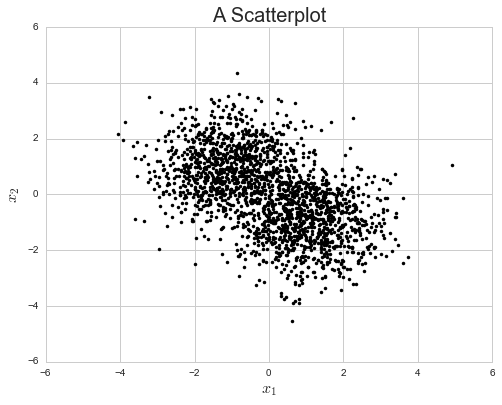

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(red, blue, 'k.')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot', fontsize = 20)

This scatterplot is familiar to everyone here.  We have two features, the pair $(x_1, x_2)$, and some label, which could be anything.  Suppose that the dots were of two flavors, $\{$red, blue$\}$.  That is, the data contain three columns, a label and two features: [flavor, $x_1$, $x_2$].  For example, [red, -2.1, 2.4].

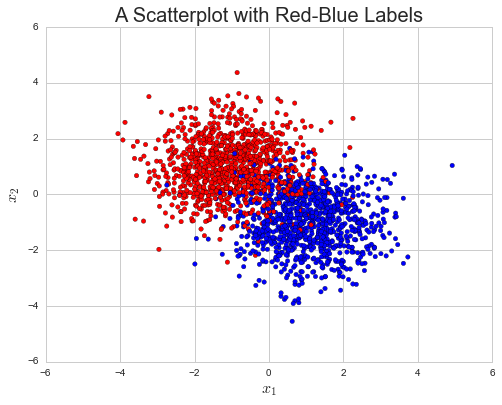

In [7]:
plt.figure(figsize = (8,6))
colors = ['red', 'blue']
plt.scatter(red, blue, c=colors)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot with Red-Blue Labels', fontsize = 20)

Classification involves developing ML models that can be used for the purpose of prediction.  Namely, suppose we have a sample of data of size $N$ for which we observe [flavor, $x_1$, $x_2$].  We can split the sample into a "training set" of size $N_1$ and a "test set" of size $N_2$, such that $N_1+N_2=N$.  

As should be clear from the names of the subsamples, we train our model using the training data.  We then assess the performance of our predictor on the test data because we can compare the label that our model predicts with the *correct* (or true) label.

Ultimately, we may wish to predict "out of sample".  Namely, if we have an a feature pair $(x_1, x_2)$ that has no label, we could predict the label based on our model.  

Look at the scatterplot above.  Notice that there is a clear delineation between the blue and red label values.  Indeed, you can almost create mentally a boundary separating the two clusters of labels.  

* Suppose you were given a feature vector of (4.2, -1.8) without a label.  What label would you attach to this unlabeled observation?

* Suppose you were given a feature vector of (-2.3, 3.9) without a label.  What label would you attach to this unlabeled observation?

* Suppose you were given a feature vector of (0, 0) without a label.  What label would you attach to this unlabeled observation?

The standard logit model could, of course, be used in this setting by mapping $\{$red, blue$\}$ to $\{$0, 1$\}$.  One would then label based on some preset threshold: assign red if the model predicts the probability of red is greater than, say, 0.5.  Interestingly, the logit is still commonly deployed as a spam filter.  Accordingly, I will quickly fit a logit model to a popular ML dataset on spam to motivate some important concepts that we do not often see in econometrics, namely a confusion matrix, ROC curves, and accuracy rates, all of which are companion measures to the mean-squared error.  I will then show a number of other popular ML techniques using a popular (if odd) dataset: 

* K Nearest Neighbors
* Random Forest
* Linear Discriminant Analysis
* Naive Bayes.  

The focus will follow the Domingos' quote above, emphasizing what they do (and how to use them) rather than on the mathematics that underlies them.

In [8]:
# Read in the data from UCI ML Library: http://archive.ics.uci.edu/ml/index.html

target_url = ("https://archive.ics.uci.edu/ml/machine-learning-databases/"
              "spambase/spambase.data")
spam = pd.read_csv(target_url, header=None, prefix="v")

# Spam indicator is v57.  Rename it.
spam.rename(columns={'v57':'spam'}, inplace=True)
print (spam['spam'].head())
print (spam['spam'].tail())
print (spam.describe())

0    1
1    1
2    1
3    1
4    1
Name: spam, dtype: int64
4596    0
4597    0
4598    0
4599    0
4600    0
Name: spam, dtype: int64
                v0           v1           v2           v3           v4  \
count  4601.000000  4601.000000  4601.000000  4601.000000  4601.000000   
mean      0.104553     0.213015     0.280656     0.065425     0.312223   
std       0.305358     1.290575     0.504143     1.395151     0.672513   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.420000     0.000000     0.380000   
max       4.540000    14.280000     5.100000    42.810000    10.000000   

                v5           v6           v7           v8           v9  \
count  4601.000000  4601.000000  4601.000000  4601.000000  4601.000000   
mean      0.095901     0.114208     0.105295     0

In [9]:
# Randomly split the dataframe as 2/3rds train and 1/3rd test.
# Many ways to do this, including object calls in pandas or scikit learn.
# Explicitly code to show what is going on.

np.random.seed(12345)
spam['index'] = np.random.uniform(low = 0, high = 1, size = len(spam))
spam['test'] = pd.get_dummies(spam['index'] <= 0.3333)[1]

# We don't need the index, so drop it.
del spam['index']

# Now we can create new train and test dataframes.
# Note the format of these command lines.
# It basically resolves as create spamtest as a subset of spam when test is 1.
# Otherwise, it is train.
spamtest = spam[spam['test'] == 1]
spamtrain = spam[spam['test'] == 0]

# Confirm data has been split properly.
print (len(spamtrain))
print (len(spamtest))
print (len(spam))

3056
1545
4601


In [10]:
# Train the logit with the first five features.
# Note that Statsmodels generates the predicted values as an numpy array.  
# Create a variable in the spamtest dataframe equal to predicted values.

logit_mod = smf.logit('spam ~ v0 + v1 + v2 + v3 + v4', data = spamtrain).fit()
print ()
print (logit_mod.summary())
pred = np.array(logit_mod.predict(spamtest))
spamtest['pred'] = logit_mod.predict(spamtest)

Optimization terminated successfully.
         Current function value: 0.608677
         Iterations 12

                           Logit Regression Results                           
Dep. Variable:                   spam   No. Observations:                 3056
Model:                          Logit   Df Residuals:                     3050
Method:                           MLE   Df Model:                            5
Date:                Thu, 12 May 2016   Pseudo R-squ.:                 0.09162
Time:                        21:22:56   Log-Likelihood:                -1860.1
converged:                       True   LL-Null:                       -2047.7
                                        LLR p-value:                 6.441e-79
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.0253      0.053    -19.426      0.000        -1.129    -0.922
v0             0.7213      

In [11]:
# With a logit predictor, you can correctly predict a 1 or correctly predict 0.
# Obviously, you can incorrectly predict a 1 or incorrectly predict a 0.
# This is the basis of the confusion matrix, together with other measures of accuracy.

print("What is a confusion matrix, and what might we do with its elements?")
print()
table = [[" ","0", "1"],["0", "TN", "FP"],["1", "FN", "TP"]]
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()

print("The True Positive Rate is TP / (TP + FN)") 
print("The False Positive Rate is FP / (TN + FP)")
print("The Accuracy Rate is (TN + TP) / (TN + FP + FN + TP)")
print("The Mean Squared Error is the Average Squared Deviation Between the Truth and Our Prediction")

What is a confusion matrix, and what might we do with its elements?

╒═══╤════╤════╕
│   │ 0  │ 1  │
├───┼────┼────┤
│ 0 │ TN │ FP │
├───┼────┼────┤
│ 1 │ FN │ TP │
╘═══╧════╧════╛

The True Positive Rate is TP / (TP + FN)
The False Positive Rate is FP / (TN + FP)
The Accuracy Rate is (TN + TP) / (TN + FP + FN + TP)
The Mean Squared Error is the Average Squared Deviation Between the Truth and Our Prediction


In [12]:
# Start with a threshold.  Initially, assume a naive threshold of 0.5.  In other words,
# it's 50-50 whether an email is spam.
# Compare our predicted classifications to the correct (or true) classifications in the test set.  
# Develop a "confusion" (or error) matrix.
# Calculate measures of precision.

threshold = 0.5
actual = spamtest['spam'].as_matrix(columns=None)
actual.astype(int)
prediction = np.zeros((len(spamtest),), dtype=np.int)
for i in range(len(prediction)): 
    if pred[i] > threshold: prediction[i] += 1

TP = 0
FP = 0
TN = 0
FN = 0

for i in range(len(prediction)):
    if actual[i] == 0:
        if prediction[i] == 0: TN += 1
        else: FP += 1    
    if actual[i] == 1:
        if prediction[i] == 0: FN += 1
        else: TP += 1

TPR = TP / (TP + FN)
FPR = FP / (TN + FP)
ACC = (TN + TP) / (TN + FP + FN + TP)
MSE = np.sum((actual - prediction)**2) / len(prediction)

table = [[" ","0", "1"],["0", TN, FP],["1", FN, TP]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()
print("The True Positive Rate is", TPR) 
print("The False Positive Rate is", FPR)
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╕
│   │  0  │  1  │
├───┼─────┼─────┤
│ 0 │ 832 │ 101 │
├───┼─────┼─────┤
│ 1 │ 408 │ 204 │
╘═══╧═════╧═════╛

The True Positive Rate is 0.3333333333333333
The False Positive Rate is 0.1082529474812433
The Accuracy Rate is 0.6705501618122978
The Mean Squared Error is 0.329449838188


In [13]:
# Not surprisingly, sklearn has libraries to do this for us.
# Call the confusion matrix and MSE libraries.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

cm = confusion_matrix(actual, prediction)
MSE = mean_squared_error(actual, prediction)

TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
TPR = TP / (TP + FN)
FPR = FP / (TN + FP)
ACC = (TN + TP) / (TN + FP + FN + TP)

table = [[" ","0", "1"],["0", TN, FP],["1", FN, TP]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()
print("The True Positive Rate is", TPR) 
print("The False Positive Rate is", FPR)
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

# Small differences are due to floating point representations.

The confusion matrix is:
╒═══╤═════╤═════╕
│   │  0  │  1  │
├───┼─────┼─────┤
│ 0 │ 832 │ 101 │
├───┼─────┼─────┤
│ 1 │ 408 │ 204 │
╘═══╧═════╧═════╛

The True Positive Rate is 0.333333333333
The False Positive Rate is 0.108252947481
The Accuracy Rate is 0.670550161812
The Mean Squared Error is 0.329449838188


In [14]:
# Clearly, the naive threshold is just that, naive.  
# Instead use as a threshold the incidence of spam in training set.

threshold = spamtrain['spam'].describe()[1]
prediction = np.zeros((len(spamtest),), dtype=np.int)
for i in range(len(prediction)): 
    if pred[i] > threshold: prediction[i] += 1

cm = confusion_matrix(actual, prediction)
MSE = mean_squared_error(actual, prediction)

TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
TPR = TP / (TP + FN)
FPR = FP / (TN + FP)
ACC = (TN + TP) / (TN + FP + FN + TP)

table = [[" ","0", "1"],["0", TN, FP],["1", FN, TP]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()
print("The True Positive Rate is", TPR) 
print("The False Positive Rate is", FPR)
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╕
│   │  0  │  1  │
├───┼─────┼─────┤
│ 0 │ 733 │ 200 │
├───┼─────┼─────┤
│ 1 │ 237 │ 375 │
╘═══╧═════╧═════╛

The True Positive Rate is 0.612745098039
The False Positive Rate is 0.21436227224
The Accuracy Rate is 0.71715210356
The Mean Squared Error is 0.28284789644


In [15]:
# It is obvious that one can automate the evaluation of TPR and FPR at a near-continuous  
# a number of different thresholds.
# In signal processing, this is called the Receiver Operating Characteristic (ROC) Curve.
# The ROC Curver traces out two types of error as we vary the threshold discriminant value. 
# The TPR is the sensitivity: the fraction of spam emails that are correctly identified, 
# using a given threshold. 
# The FPR is the fraction of non-spam emails that we classify incorrectly 
# as spam at the same threshold. 

def ROC(actual, pred, scores):
    
    tpr = np.zeros((len(scores),), dtype=np.float)
    fpr = np.zeros((len(scores),), dtype=np.float)
    acc = np.zeros((len(scores),), dtype=np.float)
    mse = np.zeros((len(scores),), dtype=np.float)
    
    for i in range(len(scores)):
        prediction = np.zeros((len(pred),), dtype=np.int)
        for j in range(len(prediction)):
            if pred[j] > scores[i]: prediction[j] += 1
                
        cm = confusion_matrix(actual, prediction)
        ms = mean_squared_error(actual, prediction)
        TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
        tpr[i] = TP/(TP + FN)
        fpr[i] = FP/(TN + FP)
        acc[i] = (TN + TP) / (TN + FP + FN + TP)
        mse[i] = ms
    
    return tpr, fpr, acc, mse

scores = np.arange(0, 1, .05)

TPR, FPR, ACC, mse = ROC(actual, pred, scores)

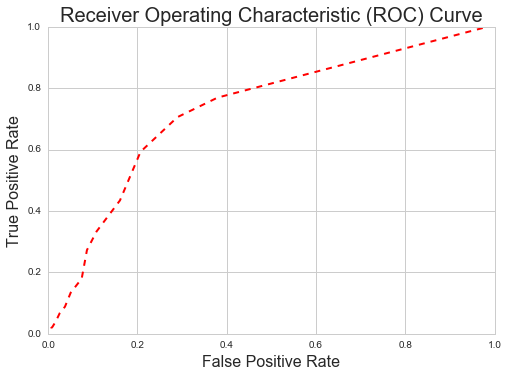

In [16]:
# The ideal ROC curve hugs the top left corner, indicating a high TPR and a low FPR. 
# A 45 degree line would represent the “no information” classifier: 
# our features cannot predict whether or not an email is spam.

plt.plot(FPR, TPR, 'r--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)

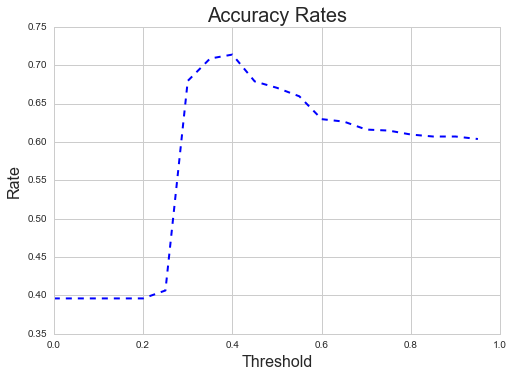

In [17]:
plt.plot(scores, ACC, 'b--', lw=2)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Rate', fontsize=16)
plt.title('Accuracy Rates', fontsize=20)

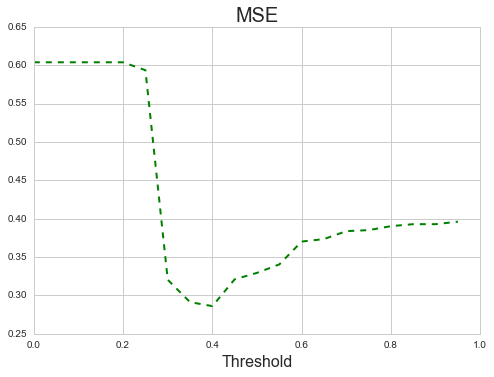

In [18]:
plt.plot(scores, mse, 'g--', lw=2)
plt.xlabel('Threshold', fontsize=16)
plt.title('MSE', fontsize=20)

## The K Nearest Neighbors (KNN) Classifier

KNN is a popular classification tool.  The name reflects exactly how the tool works (unlike many techniques in statistical learning).  Start with training data: [label, $x_1$, $x_2$].  For illustration purposes, set $K = 3$.  A candidate test data point with feature values $(x_{1j}, x_{2j})$ arrives.  The KNN predicator will determine the nearest three points in the training set based on a Euclidian distance metric, typically L2.  Given the *known* labels in the training set, the predictor will assign a label based on a majority vote.  (If $K$ is even, ties are determined by flipping a coin.)

The Euclidian distance between to two points, $(x_{1j}$, $x_{2j})$ and $(x_{1k}$, $x_{2k})$, is $\sqrt{(x_{1j} - x_{2j})^2 + (x_{1k} - x_{2k})^2}$

Let's start with a visualization to show how the KNN tool works.  

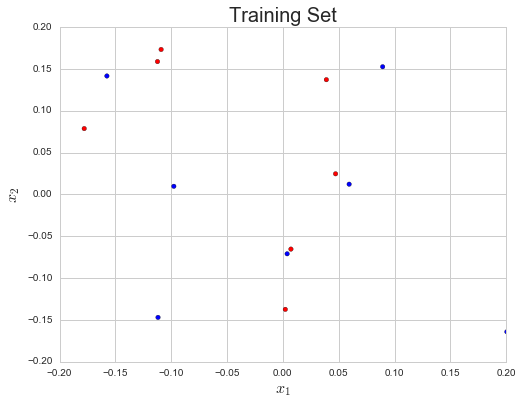

In [19]:
# Focus the scatterplot above onto a much smaller area.

plt.figure(figsize = (8,6))
colors = ['red', 'blue']
plt.scatter(red, blue, c=colors)
plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'Training Set', fontsize = 20)

* Suppose the candidate value is (0.05, 0.10).  What are the three nearest points in the training set?  How would KNN classify?
* Suppose the candidate value is (0.00, -0.05).  What are the three nearest points in the training set?  How would KNN classify?

We obviously automate the process.

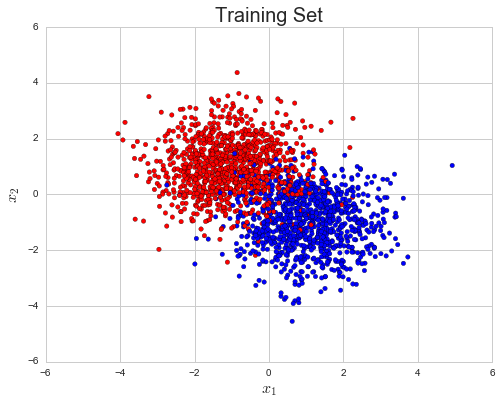

In [20]:
# Look again at the entire training set.

plt.figure(figsize = (8,6))
colors = ['red', 'blue']
plt.scatter(red, blue, c=colors)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title('Training Set', fontsize = 20)

In [21]:
# Combine original scatterplot data into a numpy array for scikit-learn.  
# This does not use Pandas as sklearn's algorithm needs numpy arrays.
# y is the label array, where 1 = red and 2 = blue (as dummy categories).
# X is the features array.

y1 = np.zeros((len(red),), dtype=np.int) + 1
y2 = np.zeros((len(blue),), dtype=np.int) + 2
y = np.append(y1, y2, axis=0)
X = np.append(red, blue, axis=0)

In [22]:
# Scikit-learn (sklearn) has a KNN algorithm, neighbors.KNeighborsClassifier, to which we pass K and the the distance metric.

# 'NN' is the number of nearest neighbors.
# 'how' is the metric used.  In the standard case, it is a Euclidean distance metric.
# 'point' is the feature values the KNN will classify.
# Start with obvious points (-2, 2), (2, -2) to confirm.
# (0.05, 0.10).  What are the three nearest points in the training set?  How would KNN classify?
# (0.00, -0.10).  What are the three nearest points in the training set?  How would KNN classify?

NN = 3
how = 'distance'
point = [0.0, -0.05]

# First line assigns the KNN object
# Second passes the object to the data for fitting and the predict.
knn = neighbors.KNeighborsClassifier(NN, how)
knn.fit(X, y)
print ("1 is Red, and 2 is Blue")
print ("KNN with %i Nearest Neighbors predicts" % (NN), knn.predict(point))

1 is Red, and 2 is Blue
KNN with 3 Nearest Neighbors predicts [2]


* Choose a number of different NN values and number of different points to obtain the KNN prediction.

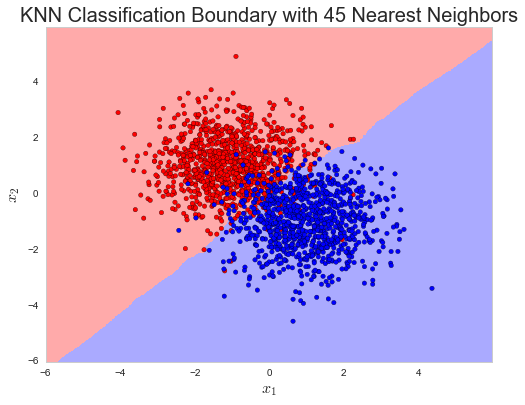

In [23]:
# Now we can consider predicting a massive number of candidates to map out the KNN classification boundary.  
# Rule of thumb on optimal K: sqrt(N)
# Such a graph would allow us to assess the performance of the KNN algorithm.

# 'background' and 'dots' are background color and dot color based on http://matplotlib.org/api/colors_api.html.
# 'NN' is the number of nearest neighbors.
# 'how' is the metric used.  In the standard case, it is a Euclidean distance metric.
# 'h' is the step size for the mesh in the graph (h is often reserved as the value for cross-validation or step size).
background = ListedColormap(['#FFAAAA', '#AAAAFF'])
dots = ListedColormap(['#FF0000', '#0000FF'])
NN = 45
how = 'distance'
h = 0.02  

# Create the KNN object and then fit it to the data.  Useful to have the object itself.
knn = neighbors.KNeighborsClassifier(NN, how)
knn.fit(X, y)

# Scatterplot above set the plot range, which is used here.
x_min, x_max = -6, 6
y_min, y_max = -6, 6
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.pcolormesh(xx, yy, Z, cmap=background)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=dots)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("KNN Classification Boundary with %i Nearest Neighbors" % (NN), fontsize = 20)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)

In [24]:
# KNN can easily be expanded to a label with three categories, which has label 'green'.

random.seed(12345)
#red = np.random.multivariate_normal([-1, 1], [[1,0],[0,1]], 1000)
#blue = np.random.multivariate_normal([1, -1], [[1,0],[0,1]], 1000)
green = np.random.multivariate_normal([-2, -2], [[1,0],[0,1]], 1000)
y1 = np.zeros((len(red),), dtype=np.int) + 1
y2 = np.zeros((len(blue),), dtype=np.int) + 2
y3 = np.zeros((len(green),), dtype=np.int) + 3
y = np.append(y1, y2, axis=0)
y = np.append(y, y3, axis=0)
X = np.append(red, blue, axis=0)
X = np.append(X, green, axis=0)

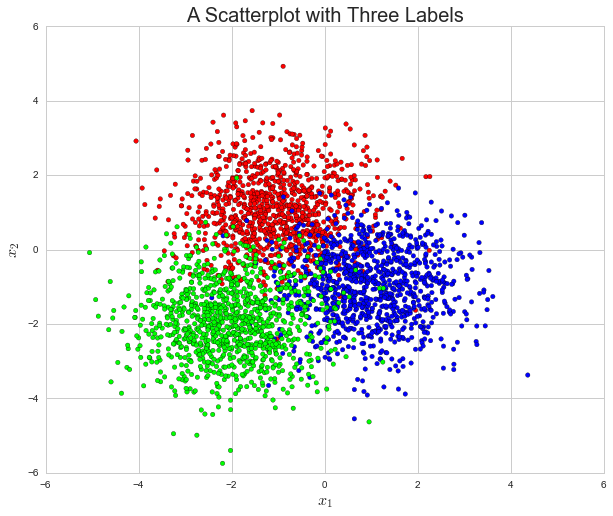

In [25]:
plt.figure(figsize = (10,8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = ListedColormap(['#FF0000', '#0000FF', '#00FF00']))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot with Three Labels', fontsize = 20)

In [26]:
NN = 25
how = 'distance'
point = [-4, 4]

knn = neighbors.KNeighborsClassifier(NN, how)
knn.fit(X, y)
print ("1 is Red, and 2 is Blue, and 3 is Green")
print ("KNN with %i Nearest Neighbors predicts" % (NN), knn.predict(point))

1 is Red, and 2 is Blue, and 3 is Green
KNN with 25 Nearest Neighbors predicts [1]


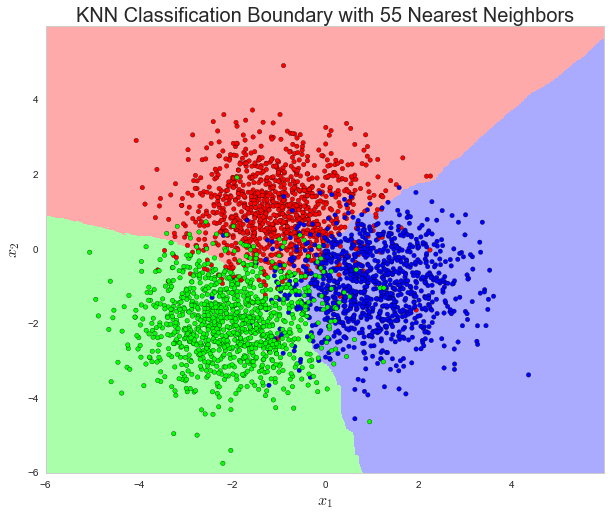

In [27]:
# Now we can consider predicting a massive number of candidates to map out the KNN classification boundary. 

# Set up inputs.
# background and dots are background color and dot color based on http://matplotlib.org/api/colors_api.html
# NN is the number of nearest neighbors
# how is the metric used.  In the standard case, it is an L2 distance metric.
# h is the step size for the mesh in the graph (h is often reserved as the value for cross-validation or step size).
background = ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA'])
dots = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
NN = 55
how = 'distance'
h = 0.02  

# Create the KNN object and then fit it to the data.  Useful to have the object itself.
knn = neighbors.KNeighborsClassifier(NN, how)
knn.fit(X, y)

# Scatterplot above set the plot range, which is used here.
x_min, x_max = -6, 6
y_min, y_max = -6, 6
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.pcolormesh(xx, yy, Z, cmap=background)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=dots)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("KNN Classification Boundary with %i Nearest Neighbors" % (NN), fontsize = 20)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)

This is Abalone


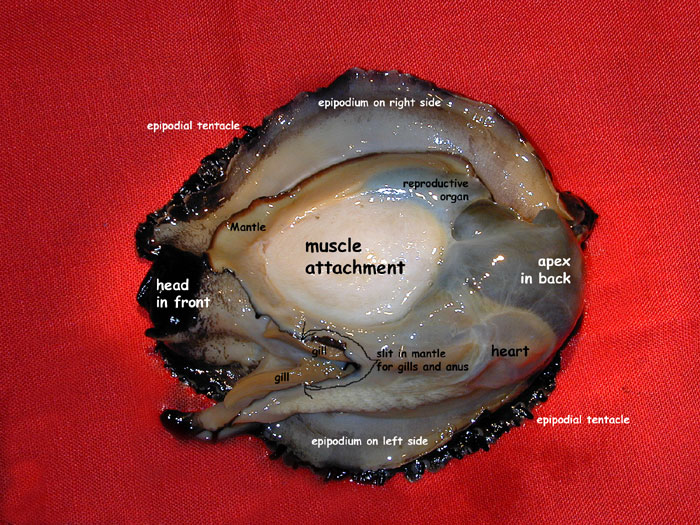

In [28]:
# Real world example.
# Use UCI archive again, this time with abalone.  
# Again, this is a curated dataset that has some key features, 
# namely that classification can be difficult.

# What's abalone?

#from PIL import Image
#import urllib.request as url
#import io

print("This is Abalone")
fd = url.urlopen("http://www.marinebio.net/marinescience/06future/abimg/aa3770.jpg")
image_file = io.BytesIO(fd.read())
Image.open(image_file) 

In [29]:
target_url = ("http://archive.ics.uci.edu/ml/machine-"
              "learning-databases/abalone/abalone.data")

# Read abalone data from UCI repository.
abalone = pd.read_csv(target_url, header=None, prefix="v")
abalone.columns = ['Gender', 'Length', 'Diameter', 'Height', 'Whole Weight',
                   'Shucked Weight', 'Viscera Weight', 'Shell Weight',
                   'Rings']

# Gender is a alpha character rather than a numeric label.  Create a numeric label {1, 2, 3} for Gender
# to pass to various machine learning predictors.
abalone['Ind'] = np.zeros((len(abalone),), dtype=np.int) + 1
for i in range(len(abalone)):
    if abalone['Gender'][i]=='I': abalone['Ind'][i] += 1
    if abalone['Gender'][i]=='M': abalone['Ind'][i] += 2

# Note the use of pandas get_dummies, which cleaves off the [0, 1] from the logical expression.
np.random.seed(12345)
abalone['index'] = np.random.uniform(low = 0, high = 1, size = len(abalone))
abalone['test'] = pd.get_dummies(abalone['index'] <= 0.3333)[1]

# We don't need the index, so drop it.
del abalone['index']

# Now we can create new train and test dataframes.
# Note the format of these command lines.
# It basically resolves as create spamtest as a subset of spam when test is 1.
# Otherwise, it is train.
abalonetest = abalone[abalone['test'] == 1]
abalonetrain = abalone[abalone['test'] == 0]

del abalone['test']
del abalonetest['test']
del abalonetrain['test']

# Confirm data has been split properly and get summary stats.
print (len(abalonetrain))
print (len(abalonetest))
print (len(abalone))
print (abalone.describe())

2791
1386
4177
            Length     Diameter       Height  Whole Weight  Shucked Weight  \
count  4177.000000  4177.000000  4177.000000   4177.000000     4177.000000   
mean      0.523992     0.407881     0.139516      0.828742        0.359367   
std       0.120093     0.099240     0.041827      0.490389        0.221963   
min       0.075000     0.055000     0.000000      0.002000        0.001000   
25%       0.450000     0.350000     0.115000      0.441500        0.186000   
50%       0.545000     0.425000     0.140000      0.799500        0.336000   
75%       0.615000     0.480000     0.165000      1.153000        0.502000   
max       0.815000     0.650000     1.130000      2.825500        1.488000   

       Viscera Weight  Shell Weight        Rings          Ind  
count     4177.000000   4177.000000  4177.000000  4177.000000  
mean         0.180594      0.238831     9.933684     2.052909  
std          0.109614      0.139203     3.224169     0.822240  
min          0.000500     

In [30]:
# In Python, most of the classifiers come from Scikit-Learn (or sklearn).
# They do not use the Panda's dataframe, but instead use Numpy arrays.
# We need to generate Numpy arrays from the train and test dataframes, which is easy to do.

ytrain = abalonetrain['Ind'].as_matrix(columns=None)
ytest = abalonetest['Ind'].as_matrix(columns=None)

Xtrain = abalonetrain[['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 
             'Viscera Weight', 'Shell Weight', 'Rings']].as_matrix(columns=None)
Xtest = abalonetest[['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 
             'Viscera Weight', 'Shell Weight', 'Rings']].as_matrix(columns=None)

# Set NN at the sqrt(4177) and evaluate at the mean.
NN = 65
how = 'distance'
point = [abalonetrain.mean()[0], abalonetrain.mean()[1], abalonetrain.mean()[2], 
         abalonetrain.mean()[3], 
        abalonetrain.mean()[4], abalonetrain.mean()[5], abalonetrain.mean()[6], abalonetrain.mean()[7]]

knn = neighbors.KNeighborsClassifier(NN, how)
knn.fit(Xtrain, ytrain)
print ()
print ("1 is Female, 2 is Infant, and 3 is Male")
print ("KNN with %i Nearest Neighbors predicts" % (NN), knn.predict(point))


1 is Female, 2 is Infant, and 3 is Male
KNN with 65 Nearest Neighbors predicts [3]


In [31]:
# Now pass the test data to the KNN predictor to generate predictions.
# Evaluate the performance using confusion matrix, accuracy rate, and mean squared error.

ypred = knn.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
KNNcm = cm
MSE = mean_squared_error(ytest, ypred)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╤═════╕
│   │  1  │  2  │  3  │
├───┼─────┼─────┼─────┤
│ 1 │ 147 │ 57  │ 234 │
├───┼─────┼─────┼─────┤
│ 2 │ 40  │ 368 │ 53  │
├───┼─────┼─────┼─────┤
│ 3 │ 170 │ 92  │ 225 │
╘═══╧═════╧═════╧═════╛
The Accuracy Rate is 0.533910533911
The Mean Squared Error is 1.34054834055


In [32]:
# What would a confusion matrix with random allocation look like?

ypred = np.random.permutation(ytest)
cm = confusion_matrix(ytest, ypred)
RANcm = cm
MSE = mean_squared_error(ytest, ypred)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╤═════╕
│   │  1  │  2  │  3  │
├───┼─────┼─────┼─────┤
│ 1 │ 146 │ 133 │ 159 │
├───┼─────┼─────┼─────┤
│ 2 │ 148 │ 159 │ 154 │
├───┼─────┼─────┼─────┤
│ 3 │ 144 │ 169 │ 174 │
╘═══╧═════╧═════╧═════╛
The Accuracy Rate is 0.345598845599
The Mean Squared Error is 1.31024531025


## Random Forest (RF) Classifier

The Random Forest Classifier is closely related to KNN because both classifiers identify a "weighted neighborhood" in the feature space, identify the known labels in that neighborhood (training set), and assign labels to unlabeled data (test set) based on a clear decision rule.  For KNN, it's majority rules with each point having the same weight.  For example, when $K=3$, KNN identifies the labels for the three closest points in the feature space.  If two are blue and one is red, the candidate receives a blue label. 

In this context, the RF classifier has a more complicated method to build the weights based on decision trees.  It  is an easy classifier to implement and has become very popular, in particular in classification of massive datasets because it is easy to parallelize the process.  In a typical setting, 100 trees works.

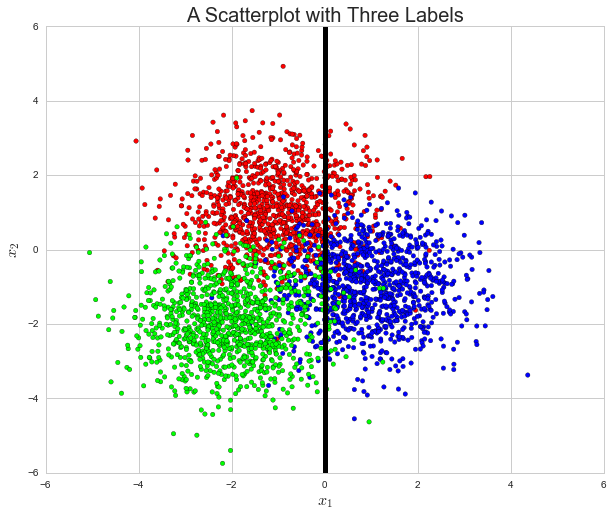

In [33]:
# A decision tree is similar to calling your bank and getting the automated teller, 
# which asks whether you're calling about a commercial or residential account;
# and then asks whether you're calling about a checking or savings account.
# A decision tree works in the identical manner by partitioning the feature space.
# The graphics below show the idea behind decision trees.
# Start by splitting the feature space at x1 = 0.
# Although this example is contrived, note that x1 > 0 predicts "blue" quite well.

plt.figure(figsize = (10,8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = ListedColormap(['#FF0000', '#0000FF', '#00FF00']))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot with Three Labels', fontsize = 20)
plt.axvline(x=0, linewidth=5, color='k')

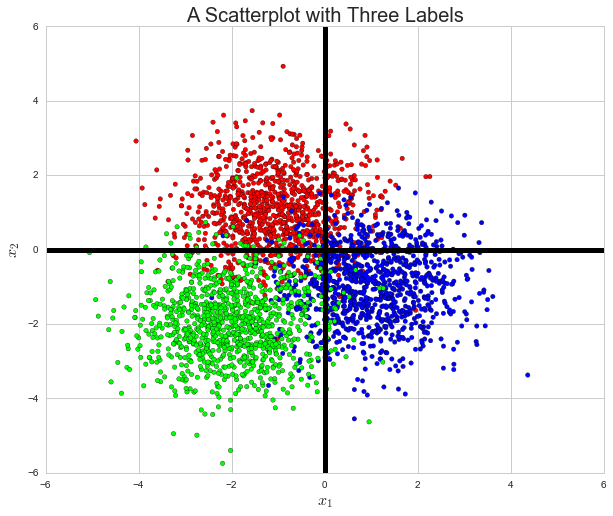

In [34]:
# Now split the the feature space at x2 = 0.
# This leads to a clear decision rule: green when x1 < 0 and x2 < 0; 
# red when x1 < 0 and x2 > 0; blue when x1 > 0 and x2 < 0; 
# continue the partition process when x1 > 0 and x2 > 0.
# For multiclass classification problems, the random forest is just a more sophisticated version of KNN 
# whereby nearer points have greater weight when the vote is taken.

plt.figure(figsize = (10,8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = ListedColormap(['#FF0000', '#0000FF', '#00FF00']))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot with Three Labels', fontsize = 20)
plt.axvline(x=0, linewidth=5, color='k')
plt.axhline(y=0, linewidth=5, color='k')

In [35]:
# Scikitlearn has a easy-to-use RF classifier.
# Let's use it on the abalone data.

from sklearn.ensemble import RandomForestClassifier

np.random.seed(12345)
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
RFcm = cm
MSE = mean_squared_error(ytest, ypred)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╤═════╕
│   │  1  │  2  │  3  │
├───┼─────┼─────┼─────┤
│ 1 │ 181 │ 52  │ 205 │
├───┼─────┼─────┼─────┤
│ 2 │ 40  │ 366 │ 55  │
├───┼─────┼─────┼─────┤
│ 3 │ 178 │ 90  │ 219 │
╘═══╧═════╧═════╧═════╛
The Accuracy Rate is 0.55266955267
The Mean Squared Error is 1.27633477633


In [36]:
# Comparing KNN, RF, and random designation.
# Remember that the on-diagonals are correctly classified.

print("1 is Female, 2 is Infant, and 3 is Male")
print("")
print("KNN Confusion Matrix")
print(KNNcm)
print()
print("RF Confusion Matrix")
print(RFcm)
print()
print("Random Confusion Matrix")
print(RANcm)

1 is Female, 2 is Infant, and 3 is Male

KNN Confusion Matrix
[[147  57 234]
 [ 40 368  53]
 [170  92 225]]

RF Confusion Matrix
[[181  52 205]
 [ 40 366  55]
 [178  90 219]]

Random Confusion Matrix
[[146 133 159]
 [148 159 154]
 [144 169 174]]


### Conclusion

We have improved classifying Females, but do slightly worse at classifying Infants and Males. It must be recognized, however, that both approaches are vastly superior to an algorithm of random assignment.

## Linear Discriminant Analysis (LDA)

As econometricians, we use the logit to classify the two-class label: $\{$yes, no$\}$, $\{$on, off$\}$, or $\{$1, 0$\}$.  We  developed a predictor based on training data by generating predicted probabilities for the test set and applying discriminant thresholds.  

Now consider a less direct method to estimating these probabilities.  In this alternative approach, we model the distribution of the features, $x_i$, separately in each of the label categories (that is, "given $y_i$").  We can apply Bayes theorem of inverse probability to determine the probability an unlabel candidate is in category $j$ *conditional* on the the data: Pr($y_i$ is in category $j$ | $x_i$).  When the feature distributions are
*assumed to be normal*, the problem become tractible, and it turns out that the model is very similar in form to logistic regression.

Why do we need another method when we have the logit classifier?

1. It's another useful tool for our toolkit, in particular when we have more than two categories for the label.
2. When the categories are well-separated in the feature space, the logit classifier does not behave well.  This is because the logit likelihood surface is essentially flat.
3. Like RF (and unlike logit or multinominal logit), this method scales with big data (because it can be parallelized).

In [37]:
from sklearn.lda import LDA

lda = LDA()
lda.fit(Xtrain, ytrain)
ypred = lda.predict(Xtest)
MSE = mean_squared_error(ytest, ypred)

cm = confusion_matrix(ytest, ypred)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╤═════╕
│   │  1  │  2  │  3  │
├───┼─────┼─────┼─────┤
│ 1 │ 129 │ 66  │ 243 │
├───┼─────┼─────┼─────┤
│ 2 │ 23  │ 360 │ 78  │
├───┼─────┼─────┼─────┤
│ 3 │ 116 │ 106 │ 265 │
╘═══╧═════╧═════╧═════╛
The Accuracy Rate is 0.544011544012
The Mean Squared Error is 1.23304473304


## The Naive Bayes (NB) Classifier

The Naive Bayes Classifier uses also Bayes' Theorem together with the naive assumption that, conditional on the label category, $j$, the value of a particular feature is independent of the value of any other feature.  In this situation, for example, Length is independent of Diameter, conditional on being Female.  Given this simplification, it simple to apply Bayes' Theorem to calculate posterior probabilties to predict a label $j$ conditional on features. 

The NB classifier has worked well in real-world situations, including spam filtering and Siri.

In [38]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
ypred = gnb.predict(Xtest)
MSE = mean_squared_error(ytest, ypred)

cm = confusion_matrix(ytest, ypred)

ACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))

table = [[" ","1", "2", "3"],
         ["1", cm[0][0], cm[0][1], cm[0][2]], 
         ["2", cm[1][0], cm[1][1], cm[1][2]], 
         ["3", cm[2][0], cm[2][1], cm[2][2]]]
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)
print("The Mean Squared Error is", MSE)

The confusion matrix is:
╒═══╤═════╤═════╤════╕
│   │  1  │  2  │ 3  │
├───┼─────┼─────┼────┤
│ 1 │ 265 │ 91  │ 82 │
├───┼─────┼─────┼────┤
│ 2 │ 34  │ 384 │ 43 │
├───┼─────┼─────┼────┤
│ 3 │ 273 │ 131 │ 83 │
╘═══╧═════╧═════╧════╛
The Accuracy Rate is 0.528138528139
The Mean Squared Error is 1.24025974026


In [39]:
# KNN, RF, LDA, MNL, and NB Classifiers using Abalone data.

NN = 65
how = 'distance'
ypred = knn.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
knnACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
knnMSE = mean_squared_error(ytest, ypred)

rf = RandomForestClassifier(n_estimators = 100)
rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
rfACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
rfMSE = mean_squared_error(ytest, ypred)

lda = LDA()
lda.fit(Xtrain, ytrain)
ypred = lda.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
ldaACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
ldaMSE = mean_squared_error(ytest, ypred)

gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
ypred = gnb.predict(Xtest)
cm = confusion_matrix(ytest, ypred)
nbACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
nbMSE = mean_squared_error(ytest, ypred)

In [40]:
# Here is the relative performance of our classifiers.

print("Accuracy")
print(knnACC, rfACC, ldaACC, nbACC)
print("")
print("MSE")
print(knnMSE, rfMSE, ldaMSE, nbMSE)

Accuracy
0.533910533911 0.542568542569 0.544011544012 0.528138528139

MSE
1.34054834055 1.29725829726 1.23304473304 1.24025974026


In [41]:
# And prediction versus randomization

ypred = np.random.permutation(ytest)
cm = confusion_matrix(ytest, ypred)
ranACC = (cm[0][0] + cm[1][1] +cm[2][2]) / (len(ypred))
ranMSE = mean_squared_error(ytest, ypred)

print("Accuracy")
print(knnACC, rfACC, ldaACC, nbACC, ranACC)
print("")
print("MSE")
print(knnMSE, rfMSE, ldaMSE, nbMSE, ranMSE)

Accuracy
0.533910533911 0.542568542569 0.544011544012 0.528138528139 0.345598845599

MSE
1.34054834055 1.29725829726 1.23304473304 1.24025974026 1.34054834055
